In [13]:
import matplotlib as mpl
from sklearn import metrics
import numpy as np
from os.path import join
import os
import pandas as pd
import re
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import collections
import numpy as np
from pathlib import Path
import warnings
import sys
sys.path.append("./../utilities/")
sys.path.append("./../additional_code/")
from helper_functions import *
from Binding_distribution import plot_binding_distribution
from betweenness import load_data_and_build_graph, calculate_exact_betweenness, analyze, plot_betweenness
CURRENT_DIR = os.getcwd()
print(CURRENT_DIR)
import warnings
warnings.filterwarnings("ignore")

/Users/vahidatabaigi/SIP3-2/code


In [14]:
# Define parameters
split_methods = ['C1f', 'C1e', 'C1', 'C2']
seeds = [42, 123, 456, 789, 999]
data_dir = join("..", "data", "training_test_results")
# Calculate aggregated results
results = aggregate_results(split_methods, seeds, data_dir)
# Create tables
inter_table, sub_table = create_results_table(results, split_methods)
# Display tables
print("Interaction Head Results:")
print(inter_table.to_string(index=False))
print("\nSubclass Head Results:")
print(sub_table.to_string(index=False))

Interaction Head Results:
Split         AUROC      Accuracy            F1
  C1f 0.917 ± 0.002 0.820 ± 0.003 0.808 ± 0.004
  C1e 0.858 ± 0.005 0.760 ± 0.005 0.774 ± 0.002
   C1 0.845 ± 0.004 0.755 ± 0.002 0.731 ± 0.004
   C2 0.842 ± 0.011 0.757 ± 0.013 0.761 ± 0.017

Subclass Head Results:
Split         AUROC      Accuracy            F1
  C1f 0.991 ± 0.001 0.933 ± 0.007 0.939 ± 0.006
  C1e 0.950 ± 0.005 0.844 ± 0.013 0.877 ± 0.008
   C1 0.951 ± 0.008 0.890 ± 0.034 0.888 ± 0.040
   C2 0.947 ± 0.005 0.871 ± 0.008 0.884 ± 0.009


# Data leakage calculations 

In [15]:
df_results = pd.read_csv(join("..", "data", "splits", "EMMA_similarity_leakage_results.csv"))
df_results["train_test_TSL"]=df_results["train_test_smiles_leakage"]+ df_results["train_test_protein_leakage"]
change_name = {'C1f':'Enzyme-based','C1e':'Small molecule-based','C1':'Label-based', 'C2':'Two-dimensional'}
df_results['Split method'] = df_results['Split method'].map(change_name)
df_results

,train_test_smiles_leakage,train_test_protein_leakage,Split method,train_test_TSL
0,0.318,0.011,Enzyme-based,0.329
1,0.279,0.200,Small molecule-based,0.479
2,0.309,0.147,Label-based,0.456
3,0.270,0.014,Two-dimensional,0.284


In [16]:
# df_avg_results = df_results.groupby('Split method').mean().reset_index()

AUROC_Inter = {"Enzyme-based":0.917, "Small molecule-based":0.858,"Label-based":0.845, "Two-dimensional":0.842}
AUROC_Sub = {"Enzyme-based":0.991, "Small molecule-based":0.950,"Label-based":0.951, "Two-dimensional":0.947}


df_results['AUROC_Inter'] = df_results['Split method'].map(AUROC_Inter)
df_results['AUROC_Sub'] = df_results['Split method'].map(AUROC_Sub)
df_results = df_results[["Split method", "train_test_smiles_leakage", "train_test_protein_leakage", "AUROC_Inter", "AUROC_Sub"]]
df_results


desired_order = ["Enzyme-based", "Small molecule-based","Label-based", "Two-dimensional"]
df_transposed = df_results.set_index('Split method').T
df_transposed = df_transposed[desired_order]
df_transposed = df_transposed.round(3)
df_transposed


Split method,Enzyme-based,Small molecule-based,Label-based,Two-dimensional
train_test_smiles_leakage,0.318,0.279,0.309,0.270
train_test_protein_leakage,0.011,0.200,0.147,0.014
AUROC_Inter,0.917,0.858,0.845,0.842
AUROC_Sub,0.991,0.950,0.951,0.947


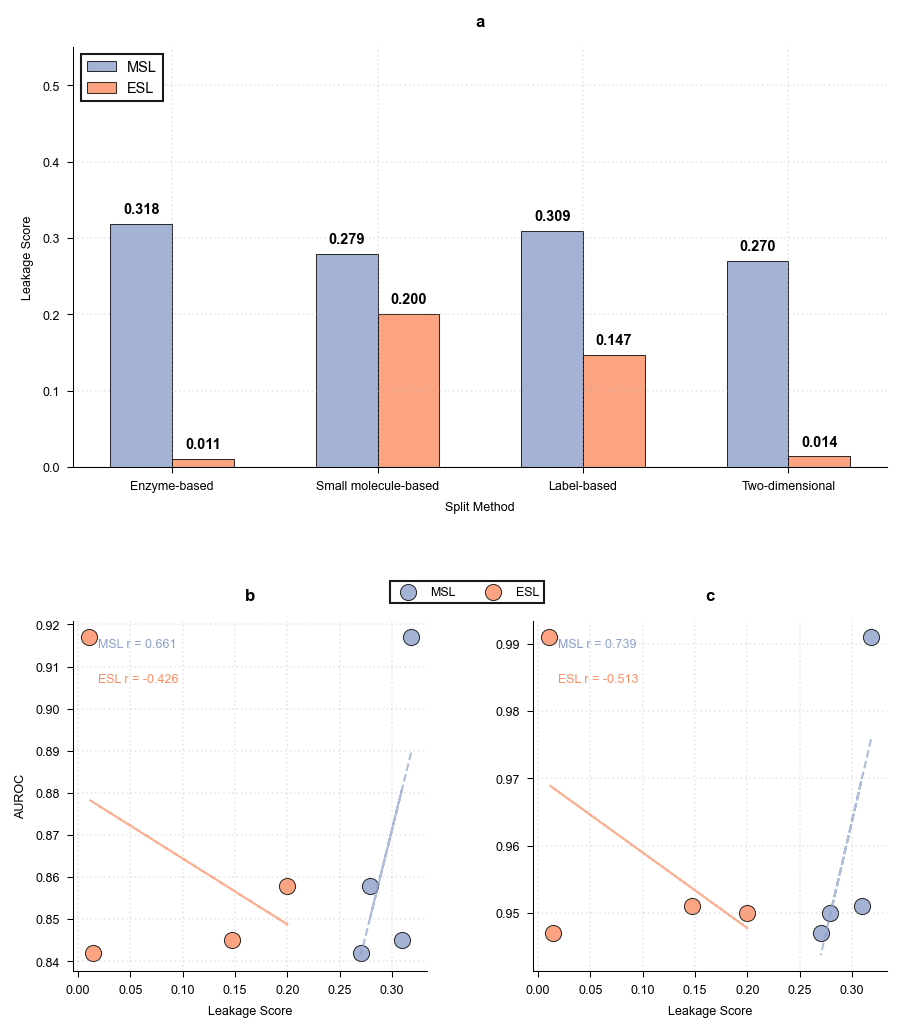

In [17]:
plot_leakage(df_results)

In [14]:
columns=["molecule_ID","Uni_SwissProt"]
splits = ["C1f", "C1e", "C1", "C2"]
leak_type=["MLSL","SLSL"]
for split in splits:
    print(f"Results for {split}")
    for column in columns:
        for leak in leak_type:
            train = pd.read_pickle(join(CURRENT_DIR, "..", "data", "splits", f"train_{split}_2S.pkl"))
            test = pd.read_pickle(join(CURRENT_DIR, "..", "data", "splits", f"test_{split}_2S.pkl"))
            train_multi = get_multi_binding(train,column,leak)
            test_multi = get_multi_binding(test,column,leak)
            shared = train_multi.intersection(test_multi)
            shared_count = len(shared)
            train_shared= train[train[column].isin(shared)]
            test_shared= train[train[column].isin(shared)]
            data_shared=pd.concat([train_shared,test_shared])
            data_shared.drop_duplicates(subset=["Uni_SwissProt", "molecule_ID", "Binding"], keep='first', inplace=True)
            print(f"{leak}:Unique {column}: {shared_count}({len(data_shared)})")

Results for C1f
MLSL:Unique molecule_ID: 467(21220)
SLSL:Unique molecule_ID: 4416(51241)
MLSL:Unique Uni_SwissProt: 0(0)
SLSL:Unique Uni_SwissProt: 0(0)
Results for C1e
MLSL:Unique molecule_ID: 0(0)
SLSL:Unique molecule_ID: 9(9)
MLSL:Unique Uni_SwissProt: 1464(61493)
SLSL:Unique Uni_SwissProt: 2734(8804)
Results for C1
MLSL:Unique molecule_ID: 341(16673)
SLSL:Unique molecule_ID: 3402(42731)
MLSL:Unique Uni_SwissProt: 94(1630)
SLSL:Unique Uni_SwissProt: 2209(15235)
Results for C2
MLSL:Unique molecule_ID: 0(0)
SLSL:Unique molecule_ID: 0(0)
MLSL:Unique Uni_SwissProt: 0(0)
SLSL:Unique Uni_SwissProt: 0(0)


# Betweenness calculations  

In [2]:
CURRENT_DIR = Path(os.getcwd())
splits = ["C1f", "C1e", "C1", "C2"]
sets=["train", "test"]
for s in splits:
    for st in sets:
        path=join(CURRENT_DIR, "..", "data", "splits", f"{st}_{s}_2S.pkl")
        df= path.split("/")[-1]
        df_name=df.split(".")[0]
        print(df_name)
        B, OUTPUT_DIR = load_data_and_build_graph(path)
        betweenness, duration = calculate_exact_betweenness(B)
        analyze(B, betweenness, OUTPUT_DIR,df_name)

train_C2_2S
Loading data and constructing graph...
Network contains 22295 nodes and 64881 edges

CALCULATING EXACT BETWEENNESS CENTRALITY
Graph size: 22295 nodes, 64881 edges
Approximate time for each dataframe: 0.30 to 1.26 hours in Mac M1

Exact betweenness calculation completed!
          : 0.27 hours

Enzyme Betweenness Statistics:
- Count: 7552.000000
- Mean: 73712.668565
- Median: 1729.286776
- Std: 485276.482306
- Min: 0.000000
- Max: 35341986.251993
- Q1: 0.000000
- Q3: 45569.689436

Molecule Betweenness Statistics:
- Count: 14743.000000
- Mean: 33648.537272
- Median: 0.000000
- Std: 280388.642085
- Min: 0.000000
- Max: 20842656.596242
- Q1: 0.000000
- Q3: 1962.921079

Analysis complete! Files saved to: /Users/vahidatabaigi/SIP3-2/code/../data/final_dataset_analysis
test_C2_2S
Loading data and constructing graph...
Network contains 8234 nodes and 16083 edges

CALCULATING EXACT BETWEENNESS CENTRALITY
Graph size: 8234 nodes, 16083 edges
Approximate time for each dataframe: 0.30 t

In [ ]:
path=join(CURRENT_DIR, "..", "data", "processed_data", "Final_Dataset.pkl")
df= path.split("/")[-1]
df_name=df.split(".")[0]
print(df_name)
B, OUTPUT_DIR = load_data_and_build_graph(path)
betweenness, duration = calculate_exact_betweenness(B)
analyze(B, betweenness, OUTPUT_DIR,df_name)

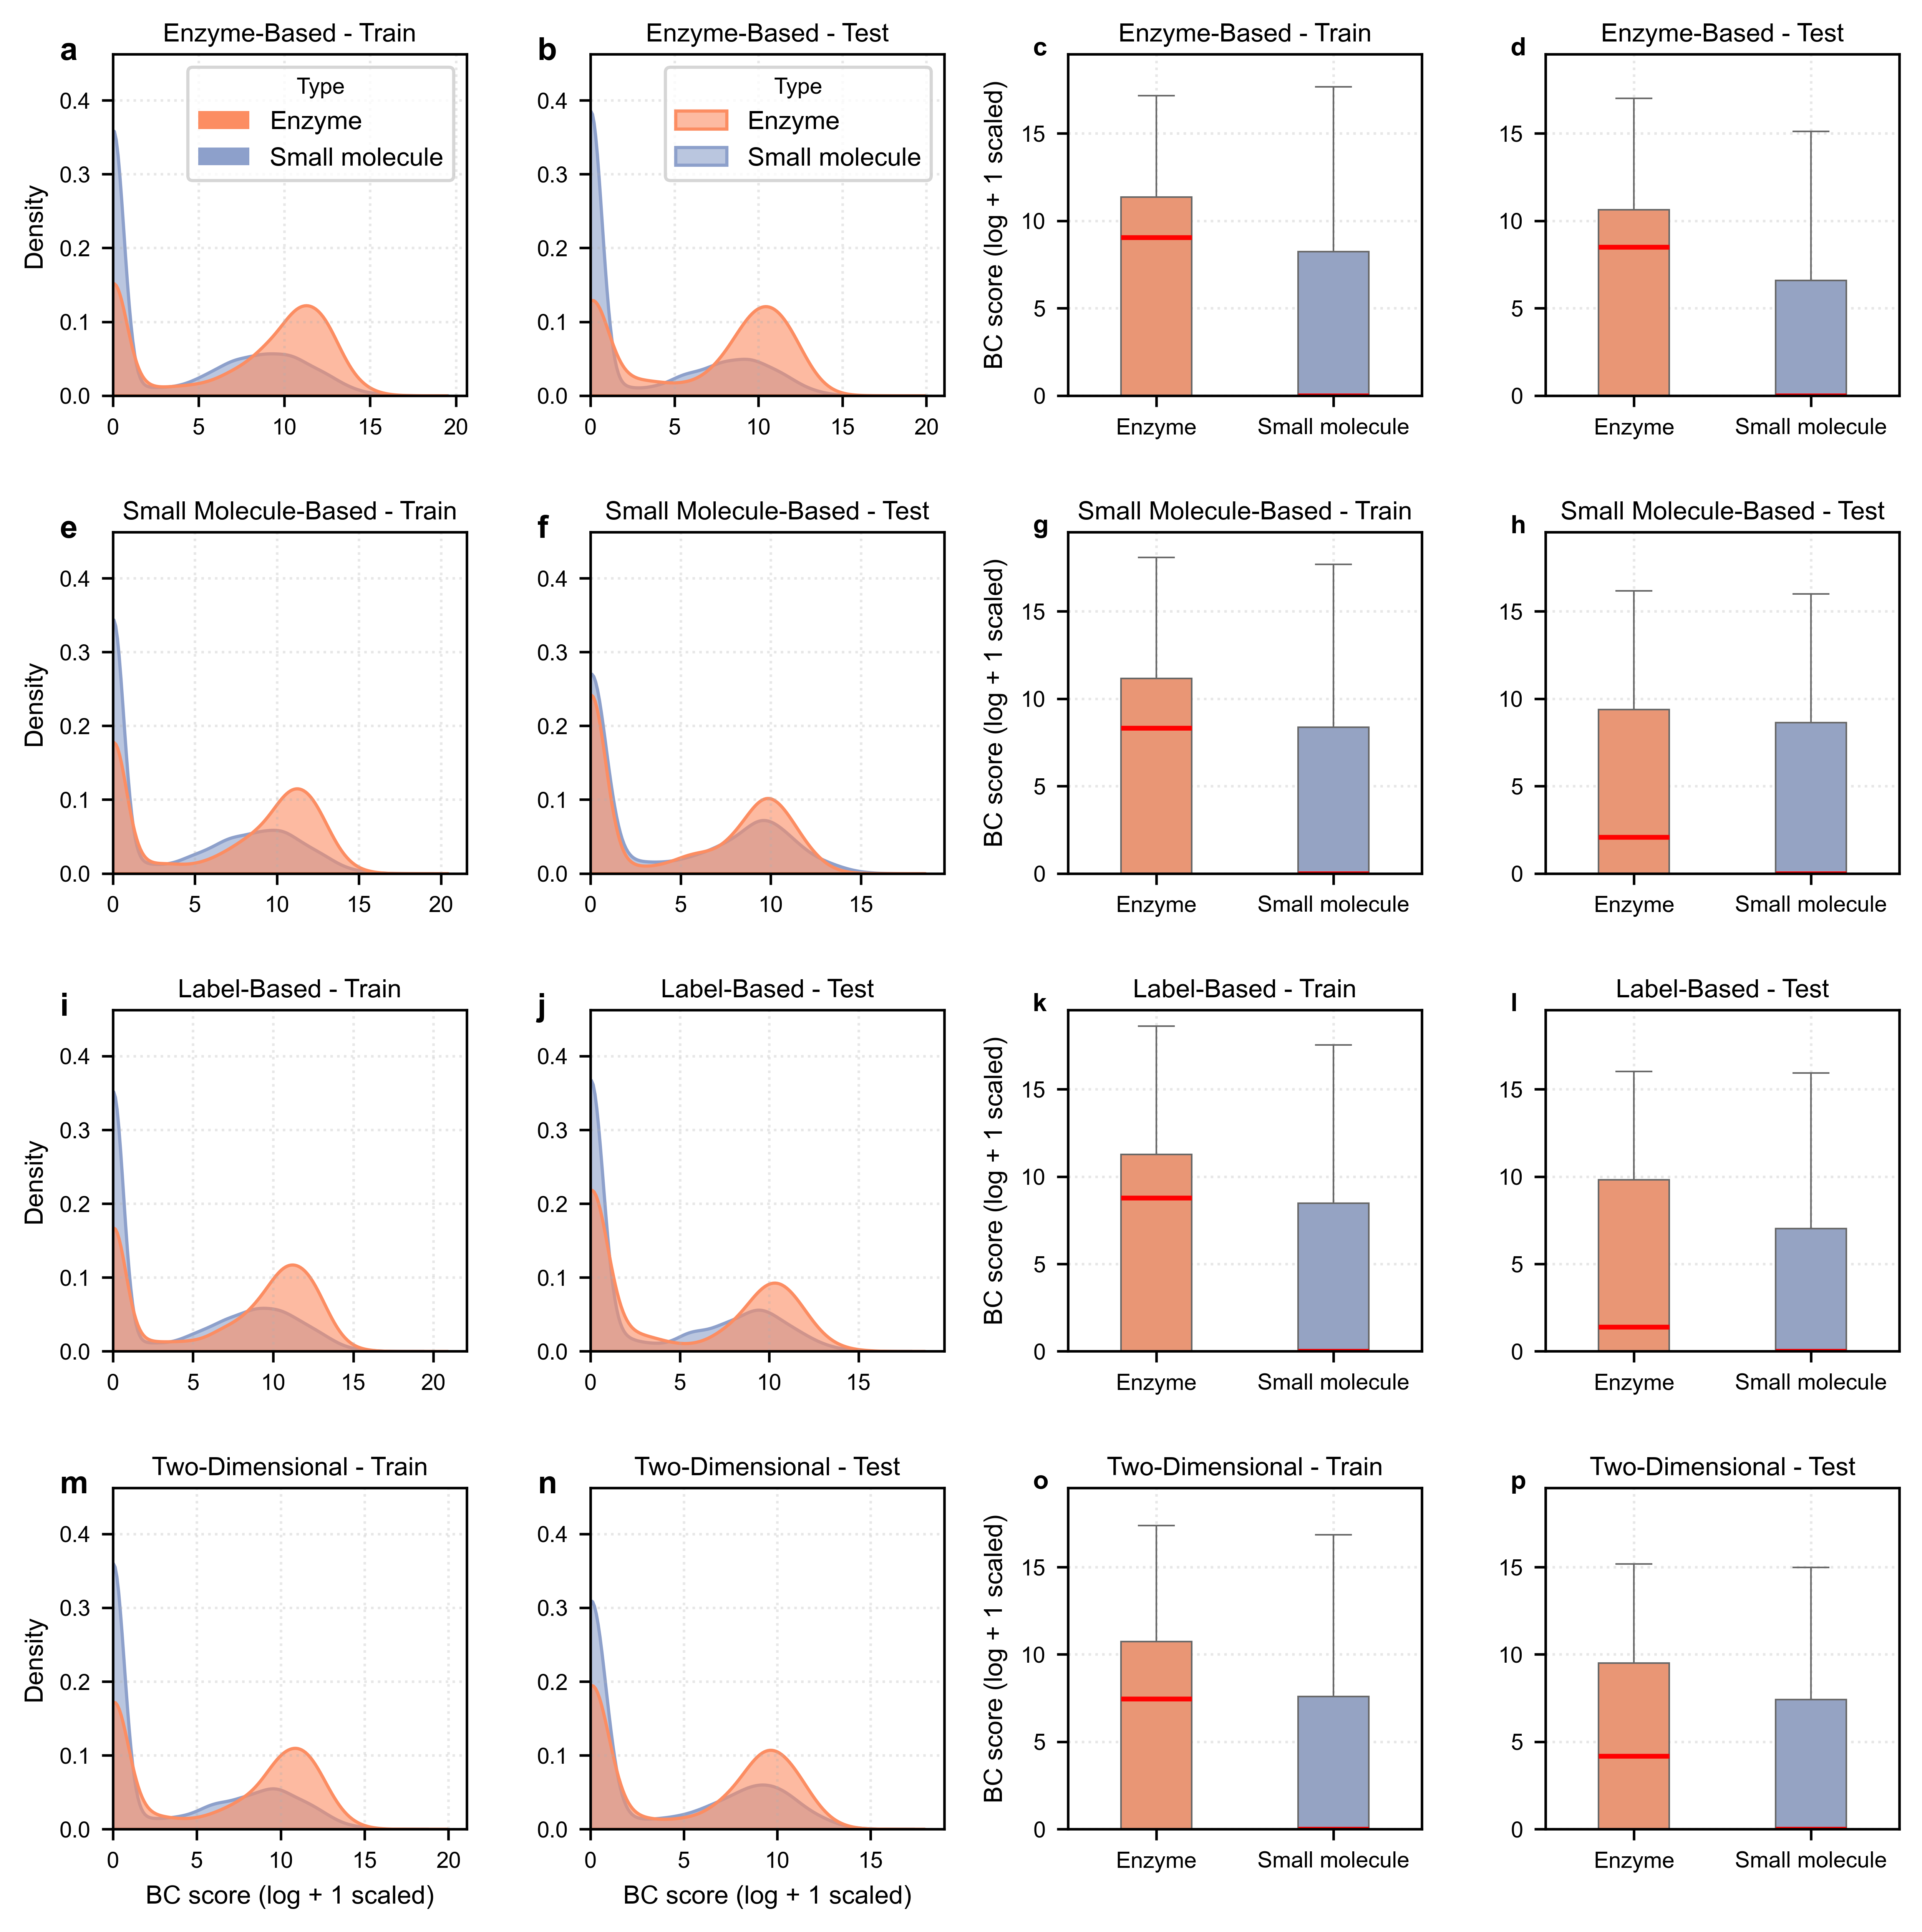

Combined analysis figure saved to: /Users/vahidatabaigi/SIP3-2/code/../data/final_dataset_analysis/betweenness_analysis_combined.pdf


In [2]:
CURRENT_DIR = Path(os.getcwd())
OUTPUT_DIR = join(CURRENT_DIR, "..", "data", "final_dataset_analysis")
plot_betweenness(OUTPUT_DIR)

# Binding distribution and average betweenness plot

In [3]:
CURRENT_DIR = Path(os.getcwd())
OUTPUT_DIR = CURRENT_DIR / ".." / "data" /"final_dataset_analysis"
# output_path = OUTPUT_DIR / "final_dataset_binding_venn_with_betweenness.png"
output_path = OUTPUT_DIR / "final_dataset_binding_venn_with_betweenness.pdf"
final_dataset = pd.read_pickle(CURRENT_DIR / ".." / "data" / "processed_data" / "Final_Dataset.pkl")
final_dataset_BC = pd.read_csv(CURRENT_DIR /OUTPUT_DIR / "betweenness_values.csv")

In [4]:
plot_binding_distribution(final_dataset, final_dataset_BC, output_path)

Combined Venn diagram with betweenness saved to: /Users/vahidatabaigi/SIP3-2/code/../data/final_dataset_analysis/final_dataset_binding_venn_with_betweenness.pdf

=== SUMMARY TABLE ===
Subset                    Avg BC          Nodes with Data Total Nodes    
----------------------------------------------------------------------

ENZYMES:
non_substrate_only        4.870           1145            1145           
substrate_only            5.417           8104            8104           
inhibitor_only            4.268           1630            1630           
substrate_inhibitor       10.961          1567            1567           
non_substrate_substrate   11.024          406             406            
non_substrate_inhibitor   11.238          1534            1534           
all_three                 12.925          1266            1266           

MOLECULES:
non_substrate_only        3.119           12540           12518          
substrate_only            3.822           5586           

# EC analysis

In [11]:
train_C2 = pd.read_pickle(join(CURRENT_DIR, ".." ,"data", "splits", "train_C2_2S.pkl"))
test_C2 =  pd.read_pickle(join(CURRENT_DIR, ".." ,"data", "splits", "test_C2_2S.pkl"))
train_C1e = pd.read_pickle(join(CURRENT_DIR, ".." ,"data", "splits", "train_C1e_2S.pkl"))
test_C1e =  pd.read_pickle(join(CURRENT_DIR, ".." ,"data", "splits", "test_C1e_2S.pkl"))
train_C1f = pd.read_pickle(join(CURRENT_DIR, ".." ,"data", "splits", "train_C1f_2S.pkl"))
test_C1f =  pd.read_pickle(join(CURRENT_DIR, ".." ,"data", "splits", "test_C1f_2S.pkl"))
train_C1 = pd.read_pickle(join(CURRENT_DIR, ".." ,"data", "splits", "train_C1_2S.pkl"))
test_C1 =  pd.read_pickle(join(CURRENT_DIR, ".." ,"data", "splits", "test_C1_2S.pkl"))
final_dataset =  pd.read_pickle(join(CURRENT_DIR, ".." ,"data", "processed_data", "Final_dataset.pkl"))

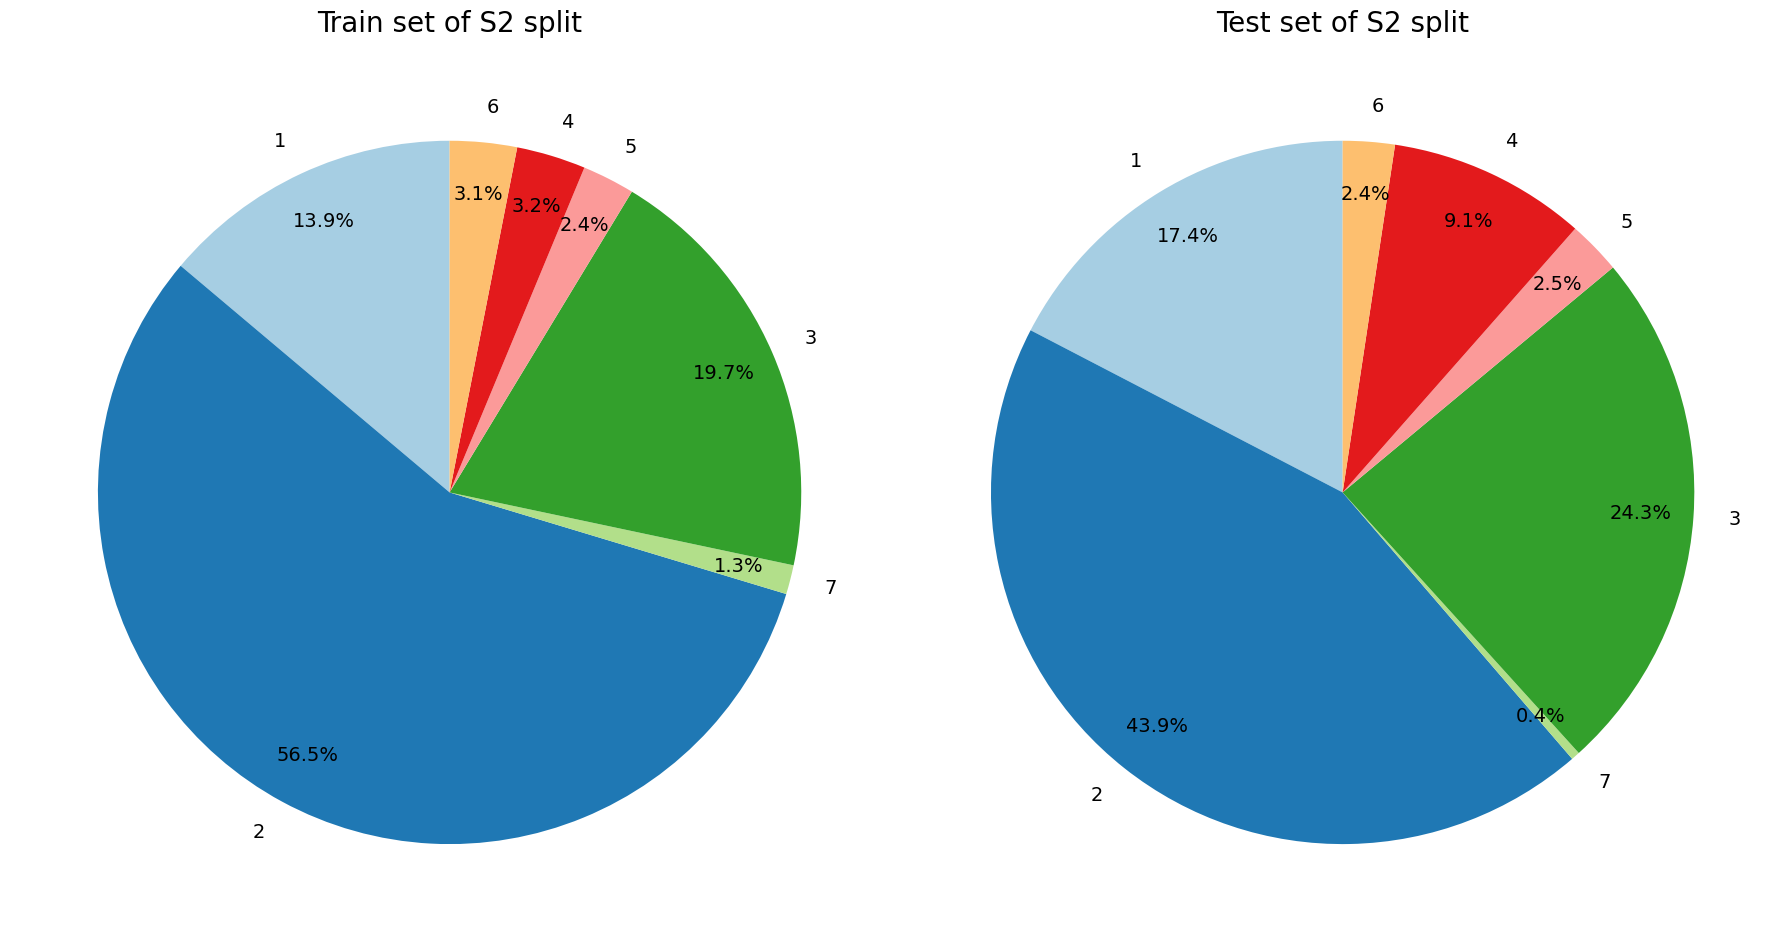

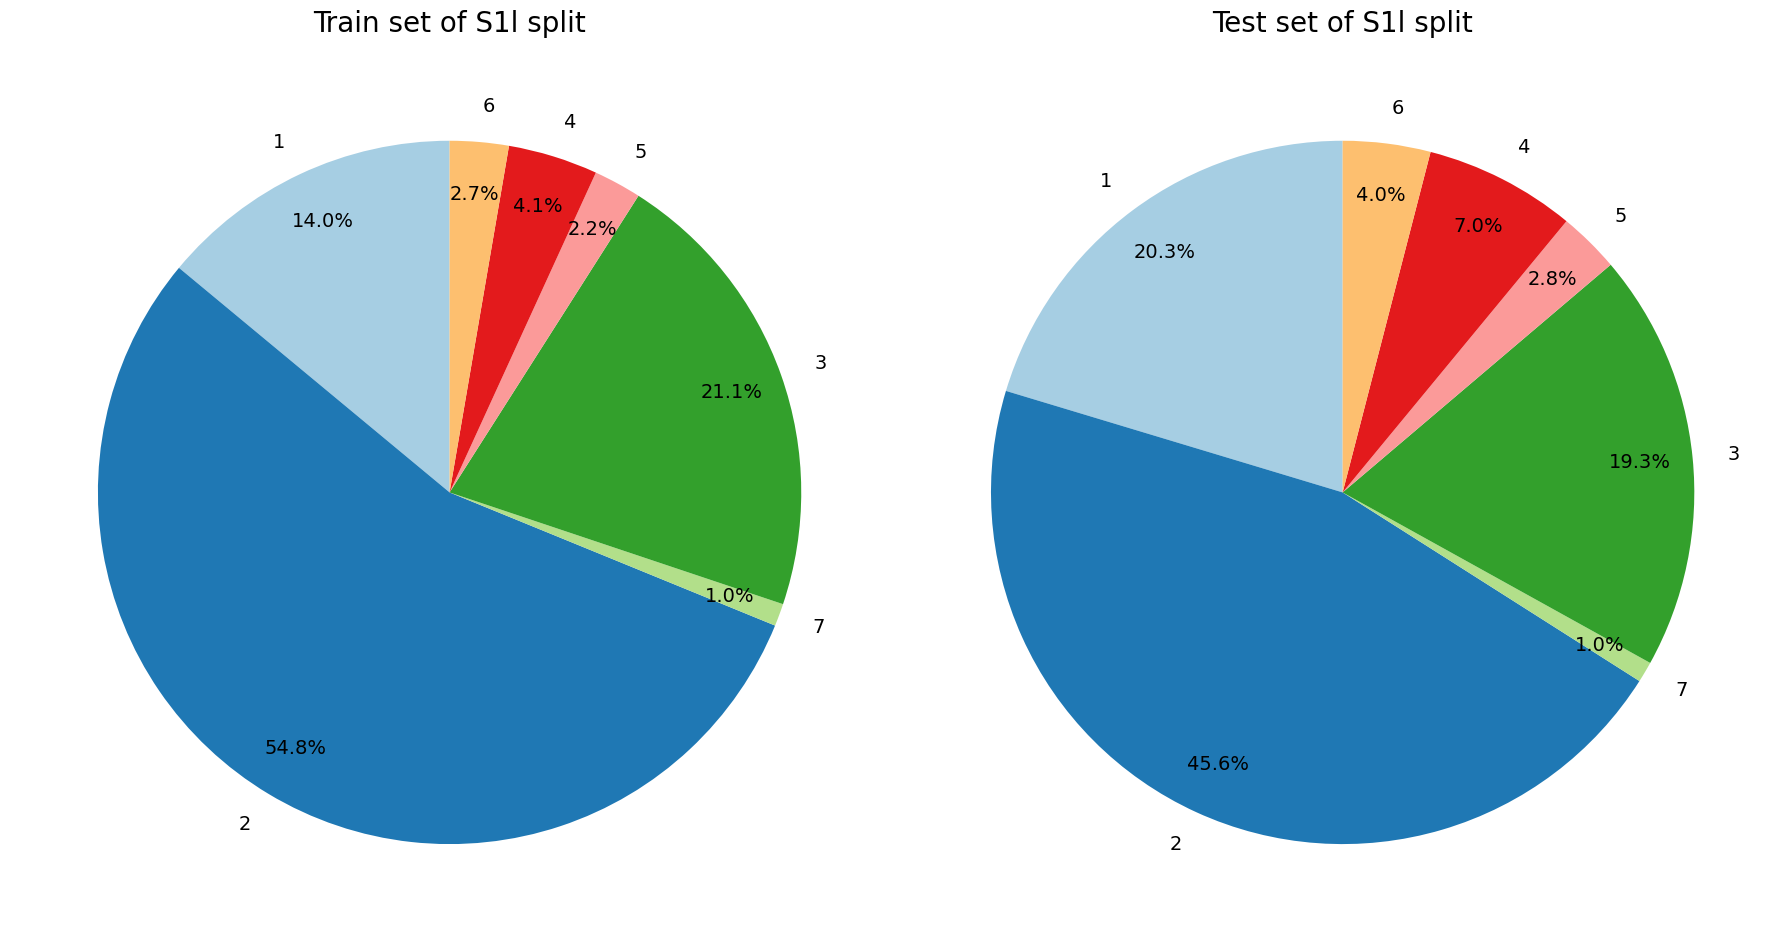

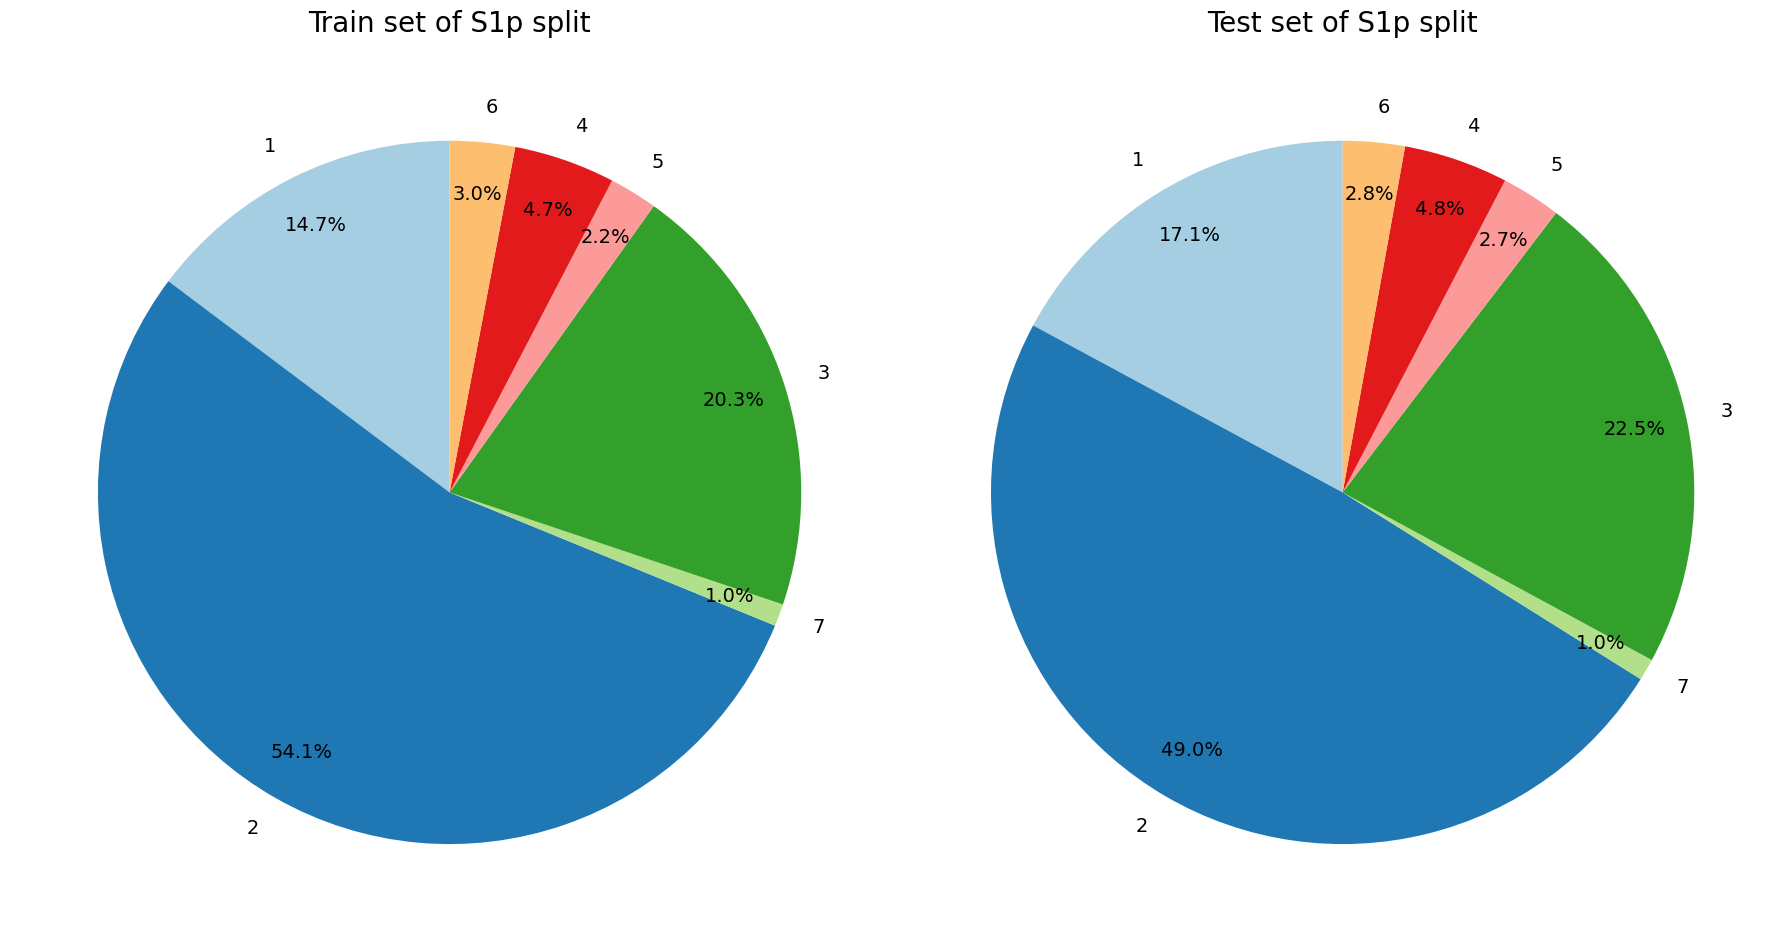

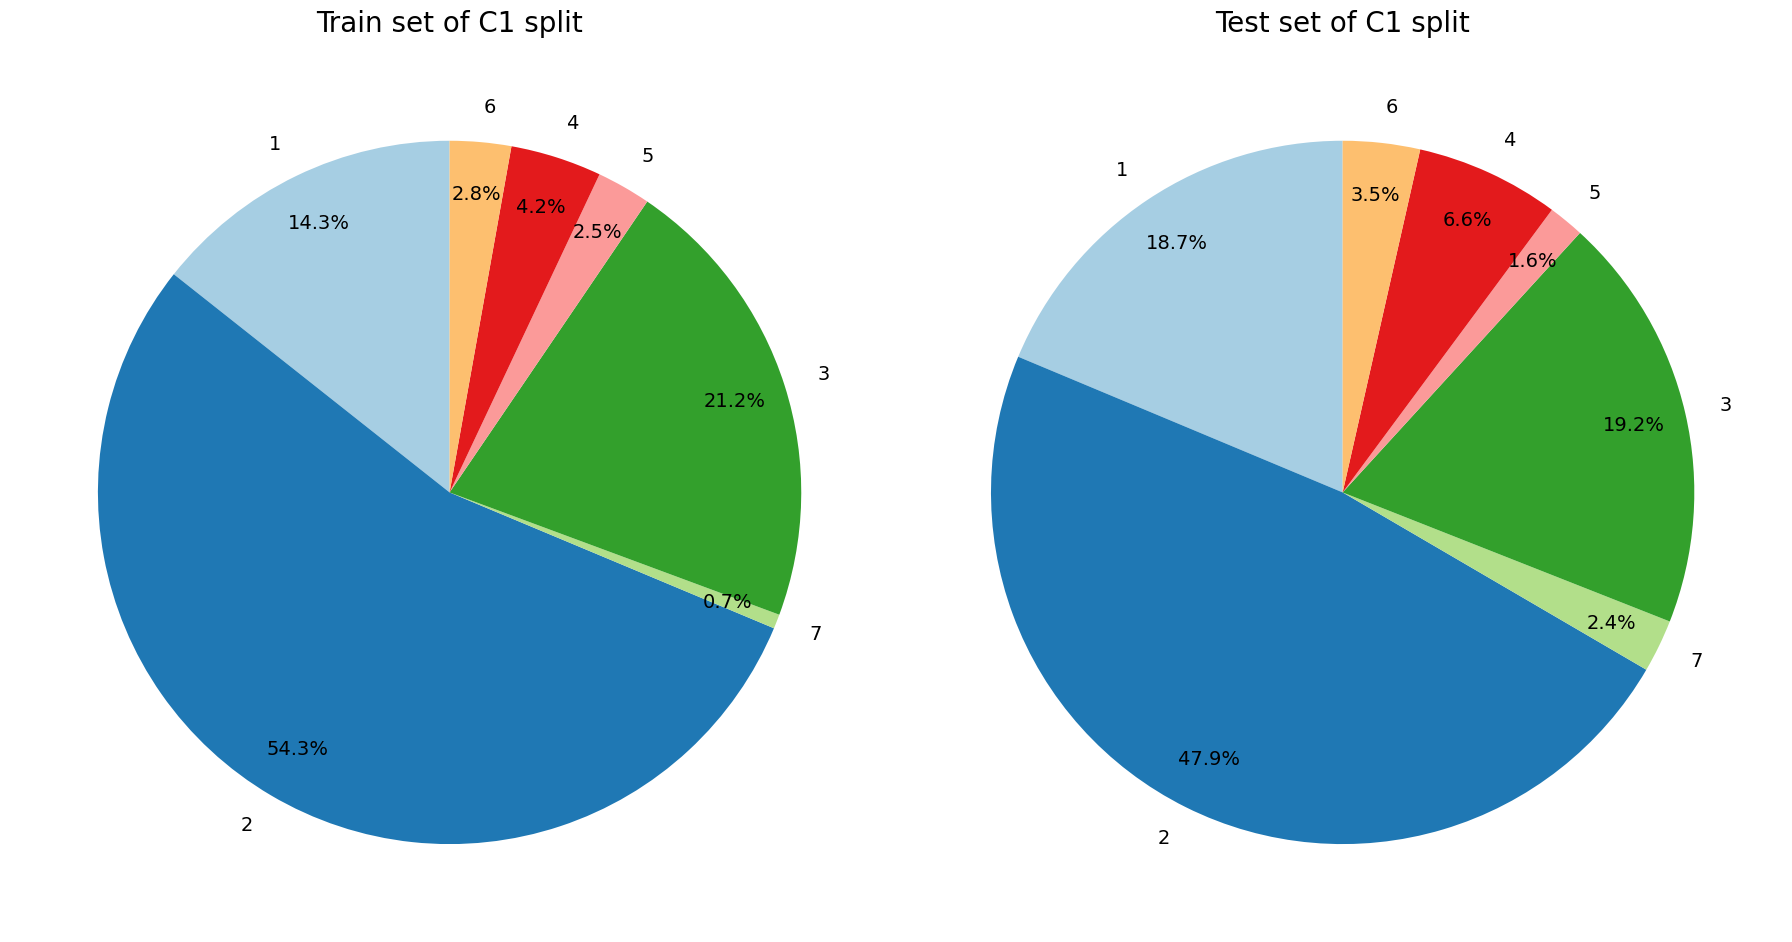

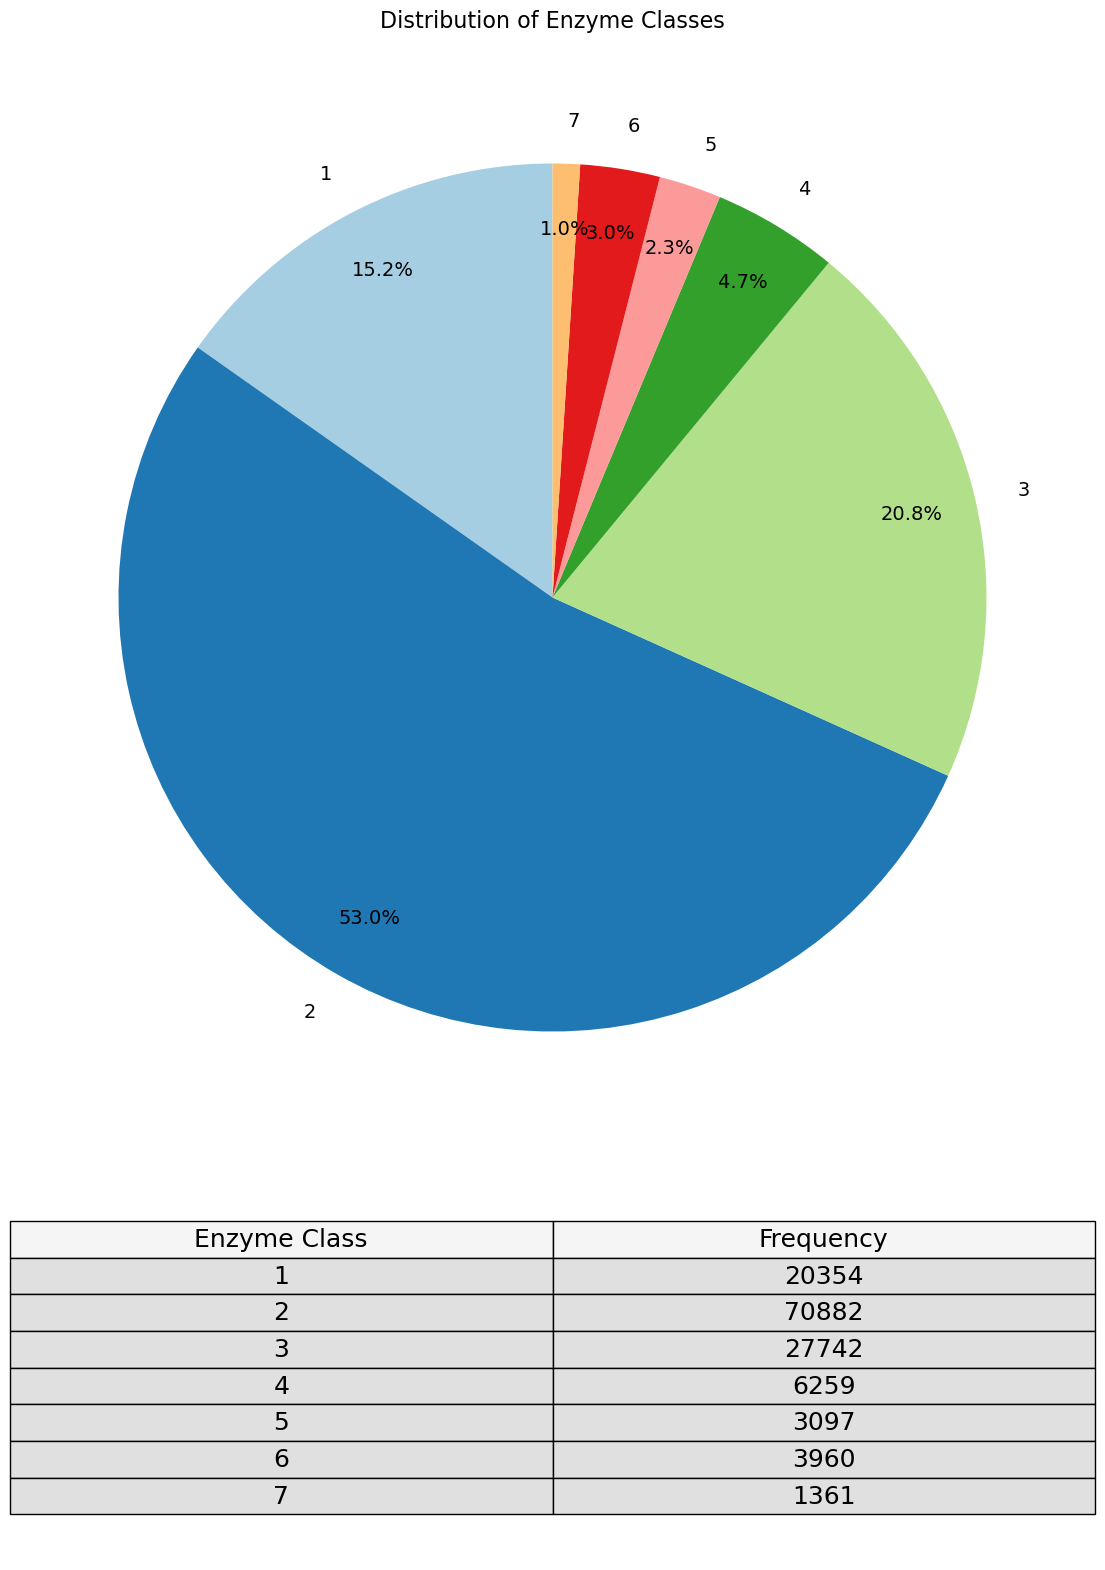

In [12]:
path = join(CURRENT_DIR,"..","data","final_dataset_analysis","C2-EC-ID.png")
ven_ec_v3(train_C2,test_C2,"S2",path)
path = join(CURRENT_DIR,"..","data","final_dataset_analysis","C1e-EC-ID.png")
ven_ec_v3(train_C1e,test_C1e,"S1l",path)
path = join(CURRENT_DIR,"..","data","final_dataset_analysis","C1f-EC-ID.png")
ven_ec_v3(train_C1f,test_C1f,"S1p",path)
path = join(CURRENT_DIR,"..","data","final_dataset_analysis","C1-EC-ID.png")
ven_ec_v3(train_C1,test_C1,"C1",path)
# add_legend=False

path = join(CURRENT_DIR,"..","data","final_dataset_analysis","finaldataset_EC-ID.png")
ven_ec(final_dataset,path)